In [1]:
print('dev branch bas')

dev branch bas


# Se importan los paquetes

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
# import pyshp as shp
import matplotlib.image as mpimg
from matplotlib import dates as mpl_dates
import flopy
from flopy.utils.gridintersect import GridIntersect
from flopy.utils.gridgen import Gridgen
from flopy.plot.map import PlotMapView
from csv import reader
from csv import DictReader
import datetime
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
%matplotlib inline
#%matplotlib notebook

from osgeo import gdal
import geopandas


from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients, get_saturated_thickness
import flopy.utils.binaryfile as bf

from flopy.utils import Raster
from flopy.utils import ZoneBudget

from scipy import interpolate
from scipy.interpolate import interpn


In [3]:
t0x = time.time()

# se crea directorio en caso de no existir para el modelo

In [4]:
if not os.path.exists('../Modelos'):
    os.makedirs('../Modelos')

os.chdir('../Modelos')
os.getcwd()

'C:\\Users\\bagutierrez\\Documents\\SQM\\12 Pasar Modelo E108 a Py-Flopy\\Prueba1\\git_DiegoHidalgo\\test_model\\Modelos'

se crea el directorio del modelo, y de los resultados y la ruta relacionada al ejecutable (modflow y gidgen)

In [5]:
modelname = 'mnsda'
model_ws = os.path.join('.', modelname)
if not os.path.exists(model_ws):
    os.makedirs(model_ws)
    
earr_ws = os.path.join(model_ws, 'ext_arrays')
if not os.path.exists(earr_ws):
    os.makedirs(earr_ws)
    
postproc_ws = os.path.join(model_ws, 'post_proc')
if not os.path.exists(postproc_ws):
    os.makedirs(postproc_ws)
    
#gridgen_exe = flopy.which('gridgen')
#mfusg_exe = flopy.which('USGs_1')

mfusg_exe=os.path.join('..','exe','USGs_1.exe')
gridgen_exe=os.path.join('..','exe','gridgen')

if mfusg_exe is None:
    msg = ('Warning, mfusg is not in your path. '
    'provide a full path to the mf6 binary executable.')
    print(msg)
else:
    print('Mfusg fue encontrado en: {}'.format(mfusg_exe))
    
if gridgen_exe is None:
    msg = ('Warning, gridgen is not in your path. '
    'provide a full path to the binary executable.')
    print(msg)
else:
    print('Gridgen fue encontrado en: {}'.format(gridgen_exe))

Mfusg fue encontrado en: ..\exe\USGs_1.exe
Gridgen fue encontrado en: ..\exe\gridgen


# Se define largo ancho y capas del modelo

rango eje x: 545700 - 593060
rango eje y: 7377200 - 7422000

In [6]:
# a large domain is defined
Lx = -(545700 - 593060)
Ly = -(7377200 - 7422000)

gl_files = ['Acuitardo_techo_2.asc','UC_techo.asc','UD_techo.asc','Basamento_V2_techo.asc']

# [ UA , UB , UC , UD , BASAM]
# Number of model layers
gls_lays = np.array([2,2,4,1,1]) # numero de capas entre capas guias
nlay = gls_lays.sum()

#Que capa corresponde al top de cada unidad relevante
layerUA_top=1

layerUB_top=gls_lays[0]+layerUA_top

layerUC_top=gls_lays[1]+layerUB_top


# Base model of 100x100 row and col
nrow = 35
ncol = 37
# Horizontal discretization
delr = Lx / ncol
delc = Ly / nrow

#periodos de estres
nper = 72

# origins
xul = 545700
yul = 7377200+delr*nrow


#cellxy x,y como tupla
cellxy = np.empty((nrow*ncol, 2), dtype=float)
inode = 0
for irow in range(nrow):
    for icol in range(ncol):
        cellxy[inode,0]=xul+delc*(icol+1/2)
        cellxy[inode,1]=yul-delr*(irow+1/2)
        inode=inode+1


# Geometría 
Se construye la geometría según las capas guías

In [7]:
topm = np.zeros((1, nrow, ncol), dtype=np.float32)

topo_file = 'DEM.asc'

pth = os.path.join("./geometrias",topo_file)
with open(pth,'r') as f:
    lines = f.readlines()
f.close()
    
asc_grid = np.loadtxt(os.path.join("./geometrias",topo_file), skiprows=6)

spatial_data = [] # ncols, nrows, xllcorner, yllcorner, dx, dy
    
for i in range(6):
    spatial_data.append(float(lines[i].split()[1]))

ncols = int(spatial_data[0])
nrows = int(spatial_data[1])
xllcorner = spatial_data[2]
yllcorner = spatial_data[3]
idelr = spatial_data[5]
idelc = spatial_data[4]
    
asc_grid = np.reshape(asc_grid,nrows*ncols)
    
truth_xy = np.empty((nrows*ncols, 2), dtype=float)
inode=0
for irow in range(nrows):
    for icol in range(ncols):
        truth_xy[inode,0]=xllcorner+idelc*(icol+1/2)
        truth_xy[inode,1]=yllcorner+nrows*idelr-idelr*(irow+1/2)
        inode=inode+1
    
elevations = interpolate.griddata(truth_xy,asc_grid,cellxy,'nearest')

inode=0
for irow in range(nrow):
    for icol in range(ncol):
        topm[0,irow,icol]=elevations[inode]
        inode=inode+1
        

In [8]:

spatial_data = [] # ncols, nrows, xllcorner, yllcorner, dx, dy

gls_elevs = np.zeros((len(gl_files)+2, nrow, ncol), dtype=np.float32) # arreglo de elevaciones para capas guias
                     
gls_elevs[0,:,:] = topm[0,:,:] # se rellena para capa 0 con el topm
gls_elevs[len(gl_files)+1,:,:] = 1800 # bottom del modelo

for i,gl_file in enumerate(gl_files):
    
    pth = os.path.join("./geometrias",gl_file)
    with open(pth,'r') as f:
        lines = f.readlines()
    f.close()
    
    asc_grid = np.loadtxt(os.path.join("./geometrias",gl_file), skiprows=6)
    
    spatial_data = [] # ncols, nrows, xllcorner, yllcorner, dx, dy
    
    for j in range(6):
        spatial_data.append(float(lines[j].split()[1]))

    ncols = int(spatial_data[0])
    nrows = int(spatial_data[1])
    xllcorner = spatial_data[2]
    yllcorner = spatial_data[3]
    idelr = spatial_data[4]
    idelc = spatial_data[4]
     
    asc_grid = np.reshape(asc_grid,nrows*ncols)
    
    truth_xy = np.empty((nrows*ncols, 2), dtype=float)
    inode=0
    for irow in range(nrows):
        for icol in range(ncols):
            truth_xy[inode,0]=xllcorner+idelc*(icol+1/2)
            truth_xy[inode,1]=yllcorner+nrows*idelr-idelr*(irow+1/2)
            inode=inode+1
    
    elevations = interpolate.griddata(truth_xy,asc_grid,cellxy,'nearest')
    
    inode=0
    for irow in range(nrow):
        for icol in range(ncol):
            if elevations[inode]<=0:
                gls_elevs[i+1,irow,icol]=gls_elevs[i,irow,icol]-1
            else:
                gls_elevs[i+1,irow,icol]=elevations[inode]
            inode=inode+1

In [9]:
# se chequea no se cruzen capas guias

for i in range(1,len(gls_elevs)):
    for irow in range(nrow):
        for icol in range(ncol):
            diff = gls_elevs[i-1,irow,icol]-gls_elevs[i,irow,icol]
            if diff <=0:
                gls_elevs[i,irow,icol]=gls_elevs[i-1,irow,icol]-1

In [10]:
# Se rellena arreglo botm

botm = np.zeros((nlay,nrow,ncol),dtype=float)

for irow in range(nrow):
    for icol in range(ncol):
        ibot = gls_elevs[0,irow,icol]
        j=0
        for i in range(1,len(gls_elevs)):
            delta = (gls_elevs[i-1,irow,icol]-gls_elevs[i,irow,icol])/(gls_lays[i-1])
            for ilay in range(gls_lays[i-1]):
                ibot = ibot-delta
                botm[j,irow,icol]=ibot
                j=j+1

In [11]:
# Se chequea que no existen celdas con espesor negativo
diff = np.zeros((nlay-1,nrow,ncol),dtype=float)

for ilay in range(1,nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            diff[ilay-1,irow,icol] = botm[ilay-1,irow,icol]-botm[ilay,irow,icol]

In [12]:
diff.min()

0.1839599609375

In [13]:
#Rellenar topm para que sea de las mismas dimensiones de bottom, se usa en alguna función

topo=topm
fila=6
colum=10

topm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
topm[0]=topo
for i in range(nlay-1):
    topm[i+1]=botm[i]
    print('layer ',i, "-celda (", fila,"--",colum,")---", topm[i][fila][colum], botm[i][fila][colum])
print('layer ',i+1, "-celda (", fila,"--",colum,")---", topm[i+1][fila][colum], botm[i+1][fila][colum])

layer  0 -celda ( 6 -- 10 )--- 2288.7717 2281.8673095703125
layer  1 -celda ( 6 -- 10 )--- 2281.8672 2274.962890625
layer  2 -celda ( 6 -- 10 )--- 2274.963 2242.990234375
layer  3 -celda ( 6 -- 10 )--- 2242.9902 2211.017578125
layer  4 -celda ( 6 -- 10 )--- 2211.0176 2173.0772094726562
layer  5 -celda ( 6 -- 10 )--- 2173.0771 2135.1368408203125
layer  6 -celda ( 6 -- 10 )--- 2135.1367 2097.1964721679688
layer  7 -celda ( 6 -- 10 )--- 2097.1965 2059.256103515625
layer  8 -celda ( 6 -- 10 )--- 2059.256 2058.256103515625
layer  9 -celda ( 6 -- 10 )--- 2058.256 1800.0


# Discretización Temporal
Se crea funcion para definir los periodos de estrés, ingresando fechas de inicio y fin, escala temporal (año, mes, día), y las otras propiedades para definición de períodos de estrés

In [14]:
def Constru_SP(year_0,month_0,day_0,year_F,month_F,day_F,escala='m',n_escala=1, steady_0=False, timestep=18, factor=2):
    '''asdasdasdasd
    asdasdasd'''
    import datetime
    
    #Definir las listas a rellenar como resultado de la funcion
    perlen = []
    nstp = []
    tsmult = []
    steady = []
    fecha_inicioSP=[]
    fecha_finSP=[]
    
    #Se definen las fechas iniciales y finales, y las variables auxiliares correspondientes a fecha inicio y termino de SP
    fecha_0=datetime.date(year_0,month_0,day_0)
    fecha_F=datetime.date(year_F,month_F,day_F)
    fecha_aux1=fecha_0
    fecha_aux2=fecha_0
    
    #Se definen ciertas condiciones de ingreso datos erroneos
    if (year_0 or year_F)>10000 and (year_0 or year_F)>1000:
        return 'Años son mayores a 10000 o menores a 1000'
        pass
    
    if (fecha_0)>=(fecha_F):
        return 'Fecha inicio mayor que fecha final'
        pass
    
    

    #Se cconstruyen las listas en base a la escala usada
    #Escala Anual 'y'
    if escala=='y':
        while fecha_aux2<fecha_F:
            fecha_aux2=datetime.date(getattr(fecha_aux2,'year')+n_escala,getattr(fecha_aux2,'month'),getattr(fecha_aux2,'day'))
            if fecha_aux2>fecha_F:
                fecha_aux2=fecha_F            
            perlen.append((fecha_aux2-fecha_aux1)/datetime.timedelta(days=1))
            fecha_inicioSP.append(fecha_aux1.isoformat())
            fecha_finSP.append(fecha_aux2.isoformat())
            fecha_aux1=fecha_aux2
            nstp.append(int(timestep))
            tsmult.append(float(factor))
            steady.append(False)
                
    #Escala Mensual 'm'
    elif escala=='m':
        while fecha_aux2<fecha_F:
            if getattr(fecha_aux2,'month')+n_escala in [13,14,15,16,17,18,19,20,21,22,23]:
                fecha_aux2=datetime.date(getattr(fecha_aux2,'year')+1,getattr(fecha_aux2,'month')+n_escala-12,getattr(fecha_aux2,'day'))
                if fecha_aux2>fecha_F:
                    fecha_aux2=fecha_F                
                perlen.append((fecha_aux2-fecha_aux1)/datetime.timedelta(days=1))
                fecha_inicioSP.append(fecha_aux1.isoformat())
                fecha_finSP.append(fecha_aux2.isoformat())
                fecha_aux1=fecha_aux2
                nstp.append(int(timestep))
                tsmult.append(float(factor))
                steady.append(False)
                
            else:
                fecha_aux2=datetime.date(getattr(fecha_aux2,'year'),getattr(fecha_aux2,'month')+n_escala,getattr(fecha_aux2,'day'))
                if fecha_aux2>fecha_F:
                    fecha_aux2=fecha_F                 
                perlen.append((fecha_aux2-fecha_aux1)/datetime.timedelta(days=1))
                fecha_inicioSP.append(fecha_aux1.isoformat())
                fecha_finSP.append(fecha_aux2.isoformat())
                fecha_aux1=fecha_aux2
                nstp.append(int(timestep))
                tsmult.append(float(factor))
                steady.append(False)

    #Escala Diaria 'd'            
    elif escala=='d':
        while fecha_aux2<fecha_F:
            fecha_aux2+=datetime.timedelta(days=n_escala)
            if fecha_aux2>fecha_F:
                fecha_aux2=fecha_F
            perlen.append((fecha_aux2-fecha_aux1)/datetime.timedelta(days=1))
            fecha_inicioSP.append(fecha_aux1.isoformat())
            fecha_finSP.append(fecha_aux2.isoformat())
            fecha_aux1=fecha_aux2
            nstp.append(int(timestep))
            tsmult.append(float(factor))
            steady.append(False)    

    else:
        pass
    #Agregar si el primero SP es steady
    steady[0] = steady_0
    
    #Resultado entregado por la funcion
    return perlen, fecha_inicioSP, fecha_finSP, nstp, tsmult, steady

help(Constru_SP)

#Ejemplo    
Constru_SP(2015,1,1,2021,1,1, escala='m', n_escala=3)

Help on function Constru_SP in module __main__:

Constru_SP(year_0, month_0, day_0, year_F, month_F, day_F, escala='m', n_escala=1, steady_0=False, timestep=18, factor=2)
    asdasdasdasd
    asdasdasd



([90.0,
  91.0,
  92.0,
  92.0,
  91.0,
  91.0,
  92.0,
  92.0,
  90.0,
  91.0,
  92.0,
  92.0,
  90.0,
  91.0,
  92.0,
  92.0,
  90.0,
  91.0,
  92.0,
  92.0,
  91.0,
  91.0,
  92.0,
  92.0],
 ['2015-01-01',
  '2015-04-01',
  '2015-07-01',
  '2015-10-01',
  '2016-01-01',
  '2016-04-01',
  '2016-07-01',
  '2016-10-01',
  '2017-01-01',
  '2017-04-01',
  '2017-07-01',
  '2017-10-01',
  '2018-01-01',
  '2018-04-01',
  '2018-07-01',
  '2018-10-01',
  '2019-01-01',
  '2019-04-01',
  '2019-07-01',
  '2019-10-01',
  '2020-01-01',
  '2020-04-01',
  '2020-07-01',
  '2020-10-01'],
 ['2015-04-01',
  '2015-07-01',
  '2015-10-01',
  '2016-01-01',
  '2016-04-01',
  '2016-07-01',
  '2016-10-01',
  '2017-01-01',
  '2017-04-01',
  '2017-07-01',
  '2017-10-01',
  '2018-01-01',
  '2018-04-01',
  '2018-07-01',
  '2018-10-01',
  '2019-01-01',
  '2019-04-01',
  '2019-07-01',
  '2019-10-01',
  '2020-01-01',
  '2020-04-01',
  '2020-07-01',
  '2020-10-01',
  '2021-01-01'],
 [18,
  18,
  18,
  18,
  18,
  18,
 

Se definen periodos de estrés

In [15]:
SP=Constru_SP(2015,1,1,2021,1,1, escala='m', n_escala=1)

perlen = SP[0]
fecha_inicialSP=SP[1]
fecha_finalSP=SP[2]
nstp = SP[3]
tsmult = SP[4]
steady = SP[5]

nper=len(perlen)
#Convertir fecha 'yyyy-mm-dd' a datetime
#from datetime import datetime
#fecha_dt=datetime.strptime(fecha_finalSP[0],'%Y-%m-%d')

    
print('largo SP \n', perlen)
print('\nnúmero de time step en SP \n', nstp)
print('\nfactor multi \n', tsmult)
print('\nFecha inicial \n', fecha_inicialSP)
print('\nFecha final \n', fecha_finalSP)
print('\nn° periodos de stress \n', nper)


largo SP 
 [31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 29.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 29.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0]

número de time step en SP 
 [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]

factor multi 
 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2

# Paquetes SIM y  DIS

In [16]:


sim = flopy.modflow.Modflow(modelname=modelname, model_ws=model_ws,
                          version='mfusg', exe_name=mfusg_exe,
                          structured=True)
dis = flopy.modflow.ModflowDis(sim, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=topm[0], botm=botm,
                              xul=xul, yul=yul, nper=nper,steady=steady,
                               perlen=perlen,nstp=nstp,tsmult=tsmult)



(1800.0, 2400.0)

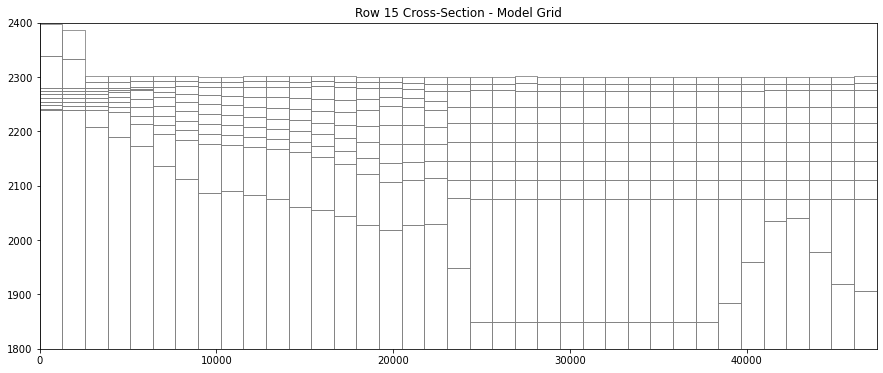

In [17]:
row=15
col=5
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
# Next we create an instance of the ModelCrossSection class
#modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': col})
modelxsect = flopy.plot.PlotCrossSection(model=sim, line={'Row':row})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelxsect.plot_grid(linewidth=0.8)
t = ax.set_title('Row {} Cross-Section - Model Grid'.format(row))
ax.set_ylim([1800,2400])

# Evaluacion geologia

In [18]:
#Id,X,Y,Z,dX,dY,dZ,HM_FinalModel on 02-06-2021

geol_unit_file = './eval_geologia/BM_HM_500x500x10.csv'

geol_units = pd.read_csv(geol_unit_file,
           header=None, names=['Id','X','Y','Z','dX','dY','dZ','GU'],
           skipinitialspace=True,skiprows=11)

geol_units.head()

,Id,X,Y,Z,dX,dY,dZ,GU
0,32453,545750,7377250,1805,500,500,10,12
1,32454,546250,7377250,1805,500,500,10,12
2,32455,546750,7377250,1805,500,500,10,12
3,32456,547250,7377250,1805,500,500,10,12
4,32457,547750,7377250,1805,500,500,10,12


In [19]:
#Elevaciones modelo geologico
geol_elev = geol_units['Z'].unique()[::-1]

#Coordenadas modelo
model_x = sim.modelgrid.xcellcenters
model_y =sim.modelgrid.ycellcenters
model_z =sim.modelgrid.zcellcenters

In [20]:
start = time.time()

geol_eval = np.zeros((nlay,nrow,ncol))

for irow in range(nrow):
    for icol in range(ncol):
        index = 0
        z_geo_select = 0
        for ilay in range(nlay):
            elev_diff = 10000
            z = model_z[ilay,irow,icol]
            for i in range(len(geol_elev)):
                ielev_diff=abs(z-geol_elev[i])
                if ielev_diff < elev_diff:
                    index = i
                    elev_diff = ielev_diff
            z_geo_select = geol_elev[index]
            df_elev_select = geol_units[geol_units['Z']==z_geo_select].values
            
            geol_xy = np.empty((len(df_elev_select), 2), dtype=float)
            
            for i in range(len(df_elev_select)):
                geol_xy[i][0]=df_elev_select[i][1]
                geol_xy[i][1]=df_elev_select[i][2]
            
            igeol = df_elev_select[:,7]
            
            ivalue = interpolate.griddata(geol_xy,igeol,(model_x[irow,icol],model_y[irow,icol]),'nearest')
            
            geol_eval[ilay,irow,icol]=ivalue
            
end = time.time()
print(end - start)

163.02011370658875


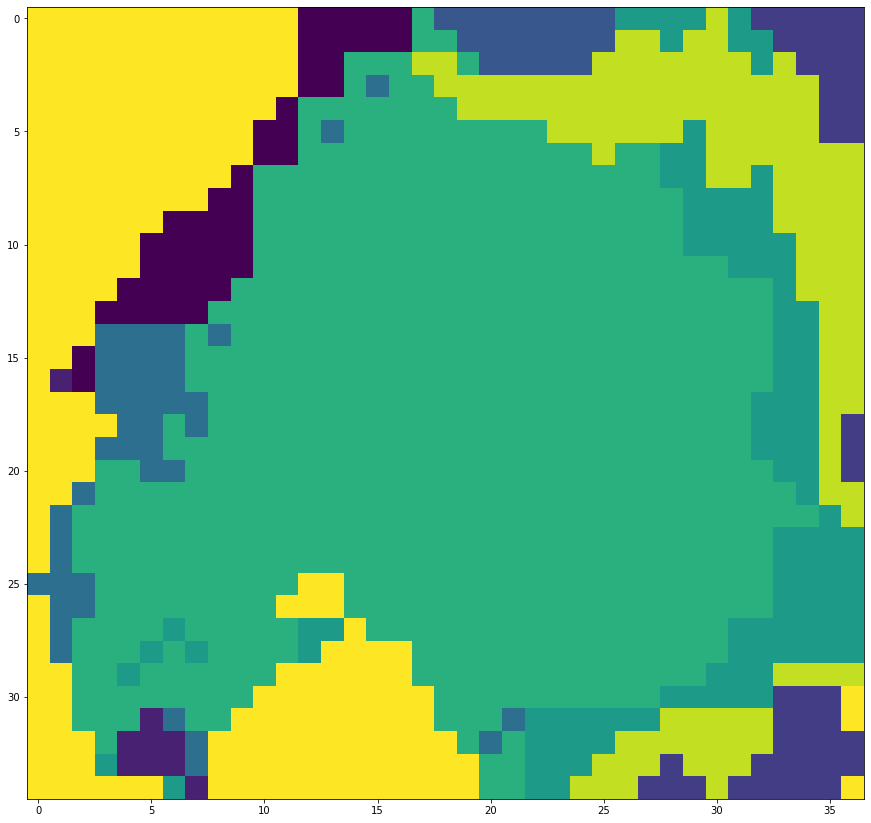

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

figure1 = ax.imshow(geol_eval[1])

(1800.0, 2400.0)

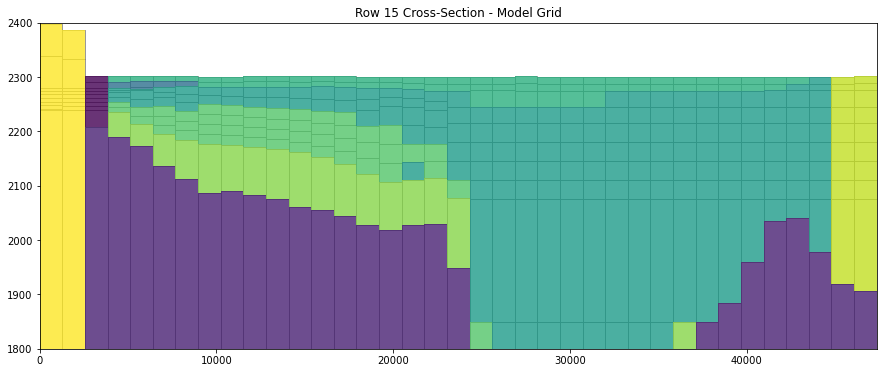

In [22]:
row=15

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
# Next we create an instance of the ModelCrossSection class
#modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
modelxsect = flopy.plot.PlotCrossSection(model=sim, line={'Row': row})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelxsect.plot_grid(linewidth=0.8)
t = ax.set_title('Row {} Cross-Section - Model Grid'.format(row))

pc = modelxsect.plot_array(geol_eval,alpha=0.8)

ax.set_ylim([1800,2400])

# Definir Celdas Activas
Crear Noflow desde shape que tenga la zona activa (el shape debe tener si es activo o no (1 o 0), y el layer de cada shape

In [23]:
def active_cell(sim,shp_noflow_obj,nlay,nrow,ncol):
    
    # Se inicializa la GridIntersect
    ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)
    
    noflow = np.zeros((nlay,nrow,ncol), dtype=int)
    
    shapeRecs = shp_noflow_obj.shapeRecords()  
    
    for ishape in shapeRecs:
        if int(ishape.record['active'])==1:
            shape = ishape.shape
            ilayer=ishape.record['layer']-1 #reemplazar si cada layer tiene 1 shape
            p = Polygon(shell=shape.points)
            result = ix.intersect(p)['cellids']
            for icell in range(len(result)):
                noflow[ilayer,result[icell][0],result[icell][1]]=1  #reemplazar 0 por ilayer si cada layer tiene 1 shape
                
    return noflow

In [24]:
# Cargar shape
shp_noflow_obj = shp.Reader('./geometria/Activo-NoActivo_dissolve.shp')

# Celdas activas
noflow = active_cell(sim,shp_noflow_obj,nlay,nrow,ncol)

In [25]:
noflow

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 

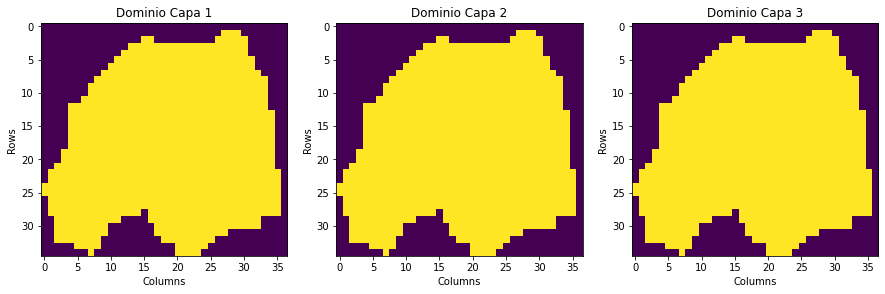

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15))

figure1 = ax1.imshow(noflow[0])
figure2 = ax2.imshow(noflow[1])
figure3 = ax3.imshow(noflow[2])

ax1.set_xlabel('Columns'); ax1.set_ylabel('Rows')
ax2.set_xlabel('Columns'); ax2.set_ylabel('Rows')
ax3.set_xlabel('Columns'); ax3.set_ylabel('Rows')

ax1.title.set_text('Dominio Capa 1')
ax2.title.set_text('Dominio Capa 2')
ax3.title.set_text('Dominio Capa 3')

In [27]:
#Corroborar que top se encuentre sobre bottom de cada layer de las celdas activas


for i in range(nlay):
    Dif_minima=0
    celda_min=0
    for j in range(nrow):
        for k in range(ncol):
            if noflow[i,j,k]==0:
                pass
            elif Dif_minima>(topm[i][j][k]-botm[i][j][k]):
                Dif_minima=topm[i][j][k]-botm[i][j][k]
                celda_min=[j,k]
    print('Layer ', i, '- Celda ', celda_min, '- Diferencia max ', Dif_minima)



Layer  0 - Celda  0 - Diferencia max  0
Layer  1 - Celda  0 - Diferencia max  0
Layer  2 - Celda  0 - Diferencia max  0
Layer  3 - Celda  0 - Diferencia max  0
Layer  4 - Celda  0 - Diferencia max  0
Layer  5 - Celda  0 - Diferencia max  0
Layer  6 - Celda  0 - Diferencia max  0
Layer  7 - Celda  0 - Diferencia max  0
Layer  8 - Celda  0 - Diferencia max  0
Layer  9 - Celda  0 - Diferencia max  0


# Se crea el paquete BAS (starting head)

Se cargan los raster relacionados a las piezometrías para las distintas unidades, y los layer definidos para cada una de estas (linker si se definen antes)

In [ ]:
bas = flopy.modflow.ModflowBas(sim, strt= 100,ibound=noflow)


In [28]:
starthead = np.ones((nlay,nrow,ncol), dtype=float)*2300
starh_UA= Raster.load('./starting_head/Mod_Nucleo_Piezo_UA_2015.asc')
starh_UB= Raster.load('./starting_head/Mod_Nucleo_Piezo_UB_2015.asc')
starh_UC= Raster.load('./starting_head/Mod_Nucleo_Piezo_UC_2015.asc')



In [29]:
def fun_starthead(starthead,sim,starh,lim_top,lim_bottom):
    dem_data = starh.resample_to_grid(
    sim.modelgrid, band=starh.bands[0], method="nearest", extrapolate_edges=True)
    dem_data_np = pd.DataFrame(dem_data).replace(pd.DataFrame(dem_data).iloc[0][0],2300*1).to_numpy() #dem_data to numpy
    
    #escribir el nivel inicial en la unidad respectiva
    starthead[(lim_top-1):(lim_bottom-1)] = dem_data_np
    
    return starthead

In [30]:
# Starting Head UA
starthead = fun_starthead(starthead,sim,starh_UA,layerUA_top,layerUB_top)
# Starting Head UB
starthead = fun_starthead(starthead,sim,starh_UB,layerUB_top,layerUC_top)
# Starting Head UC
starthead = fun_starthead(starthead,sim,starh_UC,layerUC_top,nlay+1)


In [31]:
starthead[1]

array([[2300.        , 2300.        , 2300.        , ..., 2300.        ,
        2300.        , 2300.        ],
       [2300.        , 2300.        , 2300.        , ..., 2300.        ,
        2300.        , 2300.        ],
       [2300.        , 2300.        , 2300.        , ..., 2300.        ,
        2300.        , 2300.        ],
       ...,
       [2300.        , 2300.        , 2296.96484375, ..., 2300.        ,
        2300.        , 2300.        ],
       [2300.        , 2300.        , 2300.        , ..., 2300.        ,
        2300.        , 2300.        ],
       [2300.        , 2300.        , 2300.        , ..., 2300.        ,
        2300.        , 2300.        ]])

In [32]:
arr = starh_UA.get_array(1)
idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
vmin, vmax

(2287.8037109375, 2300.993408203125)

AssertionError: Ibound/Idomain array must be provided

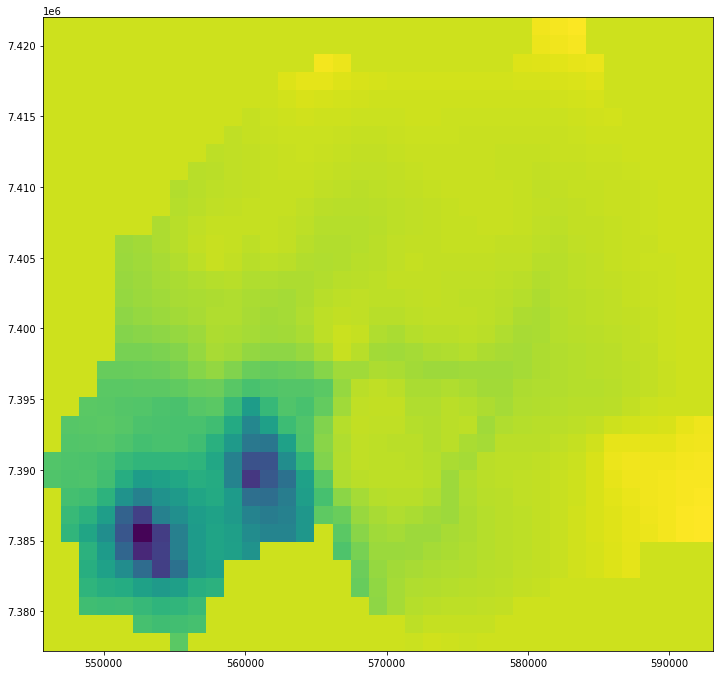

In [33]:
lay_starthead=0
# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.map.PlotMapView(model=sim)

pmv = flopy.plot.PlotMapView(modelgrid=sim.modelgrid, ax=ax)
ax = pmv.plot_array(
    starthead[lay_starthead], masked_values=starh_UA.nodatavals, vmin=vmin, vmax=vmax
)
quadmesh = modelmap.plot_ibound(color_noflow='cyan') #celdas inactivas en celeste
plt.colorbar(ax, shrink=0.7);

In [ ]:
strt = starthead

bas = flopy.modflow.ModflowBas(sim, strt= strt,ibound=noflow)
bas.write_file()

# Se crean los paquetes Lpf, Sms, Oc
Para el paquete RCH y ETS se programa su creacion. La secuencia es que primero se crean los paquetes con FLOPY Luego se agregan los paquetes RCH y ETS, actualizandose el .nam

In [ ]:
lpf = flopy.modflow.ModflowLpf(sim, hk=500, ipakcb=50, laytyp=4, layvka=1, constantcv=1, novfc=1)
lpf.write_file()


oc = flopy.modflow.ModflowOc(sim, 
                             stress_period_data={(0,0): ['print budget', 'print head', 
                                                         'save head']})

In [ ]:
sms = flopy.modflow.ModflowSms(sim,hclose=0.0001,hiclose=0.001,
                              mxiter=2000,iter1=20,iprsms=1,
                              nonlinmeth=1,linmeth=1,
                              theta=0.7, akappa=0.1, gamma=0.02,
                              amomentum=0.01,numtrack=10,btol=1.5,
                              breduc=0.2,reslim=100,clin="",
                              ipc=1,iscl=2,iord=7,rclosepcgu=0.97)
sms.write_file()

with open(os.path.join(model_ws,modelname+".sms"),'r') as f:
    lines = f.readlines()
    print(lines)
    print(len(lines))

f.close()

lines[1]=lines[1][:-1]+' SOLVEACTIVE \n'
lines[3]=lines[3][:-1]
#lines[3]='1 2 7 14 0 0.0 1 0.001 \n'
print(lines)

with open(os.path.join(model_ws,modelname+".sms"),'w') as g:
    g.writelines(lines)

g.close()


# Reconfiguración Paquete LPF
Se actualiza paquete lpf para que referencie archivos externos OPEN/CLOSE, definidos en el modelo original E108

In [ ]:
with open(os.path.join(model_ws,modelname+".lpf"),'r') as f:
    lines = f.readlines()
f.close()
with open(os.path.join(model_ws,modelname+".lpf"),'w') as g:
    for line in range(len(lines)):
        g.write(lines[line])
        if line == 6:
            break
#Se tiene código para escribir los parámetros según la cantidad de layer y la línea del parámetro
#    paraLPF6=' 0'
#    g.write(''.join([paraLPF6 for i in range(nlay)])+'\n')
    for i in range(nlay):
        g.write("OPEN/CLOSE "+"1280"+str(i+1)+"._kx 1.000000e+00 (FREE) -1 Kx Layer "+str(i+1)+"\n")
        g.write("OPEN/CLOSE "+"1280"+str(i+1)+"._kz 1.000000e+00 (FREE) -1 Kx/Kz Layer "+str(i+1)+"\n")
        g.write("OPEN/CLOSE "+"1280"+str(i+1)+"._s1 1.000000e+00 (FREE) -1 Ss Layer "+str(i+1)+"\n")
        g.write("OPEN/CLOSE "+"1280"+str(i+1)+"._s2 1.000000e+00 (FREE) -1 Sy Layer "+str(i+1)+"\n")
f.close()

In [ ]:
#se carga el paquete lpf según lo obtenido de los archivos 1280.xxx
lpf = flopy.modflow.ModflowLpf.load('mnsda/mnsda.lpf',sim)
ax = lpf.hk.plot(colorbar=True, grid=True)
#ejemplo lectura de una celda en particular
lpf.hk.array[0][24][0]  #[layer][row][column]

# CB Recarga Lateral
Se cargan las condiciones de borde de flujo lateral desde shapefile y se definen estas CBs en el modelo

In [ ]:
# Se leen las polilineas
shp_reclat_obj = shp.Reader("./recarga_lateral/recarga_lateral.shp")
shp_reclat_rec = shp_reclat_obj.records()
shp_reclat_shapes = shp_reclat_obj.shapes()

In [ ]:
#Se cargan los caudales desde archivo
q_rl2 = pd.read_csv("./recarga_lateral/Recarga_Lateral_Q.csv")
q_rl2

Se intersecta el polígono de las líneas con las condiciones de borde de recarga con la grilla (shape con polilíneas con el layer de la CB y el id de la recarga, que se lee de la tabla posterior), donde a las celdas intersectadas se les asigna un caudal según la tabla con los valores de recarga lateral.

In [ ]:
shapeRecs = shp_reclat_obj.shapeRecords()   
ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)
#Se inician variables que guardaran los nodos de RecLat, caudal, id recarga, Layer
nodos_reclat = []
qin_reclat = []
rec_reclat = []
lay_reclat = []
criterio_K=0.01

#se recorre cada shape asociado a la polilínea de recarga lateral
for shaperec in shapeRecs:
    celdas_reclat = []
    nrec = 0
    print('   ')
    #Se guarda el id de recarga y layer para cada polilínea con la recarga lateral
    rec = shaperec.record['id_recarga']
    from_layer = shaperec.record['from_layer']
    to_layer = shaperec.record['to_layer']
    print('id recarga        ', rec)
    #Se intersecta la polilínea con la grilla, guardando los id de la celda y el largo de intersección
    pline = shaperec.shape.points
    ls = LineString(pline)
    cells = ix.intersect(ls)['cellids']
    largo_inter=ix.intersect(ls)['lengths']
    print('cantidad celdas intersectadas=',len(cells))
    print('celdas intersectadas=',cells)
    # Se recorre cada celda intersectada por la polilínea, según los layer en los cuales está la CB
    #para guardar cada una de ellas
    for k in range(from_layer,to_layer+1):
        for id,icell in enumerate(cells):
            print('K= ', lpf.hk.array[k-1][icell[0]][icell[1]])
            # No se consideran celdas que se encuentran inactivas
            if noflow[k-1,icell[0],icell[1]]==0:
                print('celda inactiva', icell)
                pass
            # No se consideran celdas que la intersección sea menor al 15% del largo de la celda
            elif largo_inter[id]<0.15*delr:
                print('celda con intersección inferior a criterio de longitud', icell)
                pass
            elif lpf.hk.array[k-1][icell[0]][icell[1]]<criterio_K:
                print('celda con intersección inferior a criterio de K', icell)
                pass
            else:
            #Se guarda el id de recarga, la celda, y el layer de la celda intersectada
                rec_reclat.append(rec)
                celdas_reclat.append(icell)
                lay_reclat.append(k)
    nrec = len(celdas_reclat)
    print('cantidad celdas totales=', nrec)
    # se divide el caudal total de la polilínea por la cantidad de celdas intersectadas
    iq_rl = q_rl2[q_rl2['id_recarga']==rec]['Q(m3/d)'].tolist()
    iq_rl=iq_rl[0]/nrec
    print('Q celda',iq_rl)
    #Se asocia un caudal a cada celda intersectada
    for icell in celdas_reclat:
        nodos_reclat.append(icell)
        qin_reclat.append(iq_rl)
print('')
print(len(lay_reclat),' ',lay_reclat)        
print('')
print(len(nodos_reclat),' ',nodos_reclat)
print('')
print(len(qin_reclat),' ',qin_reclat)

wel_dtype = [('k', '<i8'), ('i', '<i8'), ('j', '<i8'), 
              ('flux', '<f4'), ('iwel', '<i4')]
wel_dtype = np.dtype(wel_dtype)

sp1 = np.zeros((len(nodos_reclat)), dtype=wel_dtype)
sp1 = sp1.view(np.recarray)

# se leen las celdas, y se asigna una variable auxiliar asociada con la zona de recarga
for icell in range(len(nodos_reclat)):
    print(icell)
    sp1[icell]=(lay_reclat[icell]-1,nodos_reclat[icell][0],nodos_reclat[icell][1]
                ,qin_reclat[icell],rec_reclat[icell]+100)

print(sp1)

# Ahora se repite la operacion pero para el SP2, tal de generar la variable auxiliar que
# diferencia esta condicion de borde del SP1. El valor de variable auxiliar es 200+Z donde
# es el numero de zona identificado

sp2 = np.zeros((len(nodos_reclat)), dtype=wel_dtype)
sp2 = sp2.view(np.recarray)

for icell in range(len(nodos_reclat)):
    sp2[icell]=(lay_reclat[icell]-1,nodos_reclat[icell][0],nodos_reclat[icell][1]
                ,qin_reclat[icell],rec_reclat[icell]+200)

print(sp2)



In [ ]:
stress_period_data = {0:sp1,1:sp2}
wel1 = flopy.modflow.ModflowWel(sim, ipakcb=50,stress_period_data=stress_period_data,
                                dtype=wel_dtype,options=['AUTOFLOWREDUCE','aux iwel'])
print("Se construye correctamente packete wel1")

,
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sim.modelgrid.plot(ax=ax)

for irow, icol in nodos_reclat:
    h2, = ax.plot(sim.modelgrid.xcellcenters[0, icol], sim.modelgrid.ycellcenters[irow, 0],
                  "kx", label="centroids of intersected gridcells")

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

# Bombeo-Extracciones
Se lee el archivo con los datos de pozos de bombeo para crear paquete WELL


In [ ]:
# Se lee archivo de ubicacioan de pozos

wells_ubi = pd.read_csv("./well/Ubicacion_Well_all.csv")
wells_ubi.head()

In [ ]:
# Se lee archivo de bombeo

wells = pd.read_csv("./well/Serie_Well_all.csv")
wells.head()

In [ ]:
def well_to_day(df):
    '''Convierte del DataFrame mensual en un caudal uniforme diario
    retornando un diccionario con los caudales diarios de todos los pozos'''
    
    dic_well = {} #diccionario vacio donde se almacenará el DataFrame de cada pozo
    name_well = df['pozo'].unique() #nombre de los pozos
    num_well = len(df['pozo'].unique()) #cantidad de pozos

    for i in range(num_well): #recorrer los pozos
        df_well = df[df['pozo'] == name_well[i]]
        df_well.reset_index(drop=True,inplace=True)  

        df_new = pd.DataFrame(columns = ['Days','Flow']) #DataFrame a rellenar

        for j in range(len(df_well['Fecha_inicio'])): #recorrer meses de cada pozo
            date_i = datetime.datetime.strptime(df_well['Fecha_inicio'][j], "%d/%m/%Y")
            date_f = datetime.datetime.strptime(df_well['Fecha_fin'][j], "%d/%m/%Y")
            delta = date_f - date_i

            days = []
            for k in range(delta.days): #agregar dias del mes
                days.append(date_i + datetime.timedelta(days=k))

            #almecenar datos
            df_aux = pd.DataFrame()
            df_aux['Days'] = days
            df_aux['Flow'] = np.repeat(df_well['Caudal_m3/d'][j],len(days))

            #concaquetar datos
            df_new = pd.concat([df_new,df_aux],axis=0)

        #guardar datos en diccionario
        df_new.reset_index(drop=True,inplace=True)
        dic_well[name_well[i]] = df_new
    
    return dic_well

In [ ]:
dic_well_day = well_to_day(wells)

In [ ]:
def well_to_SP(SP,dic_well):
    
    #Data del SP
    fecha_inicialSP=SP[1]
    fecha_finalSP=SP[2]
    
    name_well = list(dic_well.keys())
    
    df_sp = pd.DataFrame(columns = ['pozo','sp','Fecha_inicio','Fecha_fin','Caudal']) #DataFrame a rellenar
    
    for well in name_well: #recorrer pozos
        df_well = dic_well[well]
        Caudal = []
        sp = []
        
        for i in range(len(fecha_inicialSP)):
            sp.append(i+1)
            
            #Filtrar segun fechas
            f_i = df_well['Days'] >= fecha_inicialSP[i]
            f_f = df_well['Days'] < fecha_finalSP[i]
            filt = f_i & f_f
            Caudal.append(np.mean(df_well.loc[filt]['Flow'])) #Caudal promedio segun fechas establecidas
            
        dic = {'pozo':[well]*len(sp),'sp':sp,'Fecha_inicio':fecha_inicialSP,'Fecha_fin':fecha_finalSP,'Caudal':Caudal}         
        df_sp_well = pd.DataFrame(dic) #DataFrame de un pozo
        
        df_sp = pd.concat([df_sp,df_sp_well],axis=0) 
        

    df_sp.dropna(subset = ["Caudal"], inplace=True) #Eliminar filas NaN
    df_sp.reset_index(drop=True,inplace=True)       #Reiniciar index
    
    return df_sp

In [ ]:
df_well_to_sp = well_to_SP(SP,dic_well_day)

In [ ]:
df_well_to_sp.loc[df_well_to_sp.pozo=='ARPES-01']

In [ ]:
df_well_to_sp.tail(50)

In [ ]:
ALB_bot_well=5

#asignar los layer a cada uno de los pozos, van desde 1 a nlay
top_lay_well=np.ones(len(wells_ubi['pozo']),dtype='int')
bot_lay_well=np.ones(len(wells_ubi['pozo']),dtype='int')

#se recorre cada pozo, guardando ubicacion, compañia 
for n,pozo in enumerate(wells_ubi['pozo']):
    x=wells_ubi.loc[n,'X']
    y=wells_ubi.loc[n,'Y']
    comp=wells_ubi.loc[n,'Comp']
    pt = Point(x,y)
    cells = ix.intersect(pt)['cellids'] 
    print(cells)
    
    #Se asigna a los pozos de ALB un layer por defecto, variable de asignación previa
    if comp=='ALB':
        bot_lay_well[n]=ALB_bot_well
        top_lay_well[n]=1    
    else:
        
        #Se asignan valores de layer si es que queda sobre la grilla del modelo o bajo 
        if (wells_ubi.loc[n,'Bot_scr']<=(botm[nlay-1][cells[0]])):
            bot_lay_well[n]=nlay
    
        if (wells_ubi.loc[n,'Top_scr']>=(topm[0][cells[0]])):
            top_lay_well[n]=1

        
        #se recorre cada bottom layer desde abajo hacia arriba 
        for i in range(nlay,0,-1):
            if (wells_ubi.loc[n,'Bot_scr']>=(botm[i-1][cells[0]])) & (wells_ubi.loc[n,'Bot_scr']<=(topm[i-1][cells[0]])):
                bot_lay_well[n]=i
                break
            
        for i in range(nlay,0,-1):
            if (wells_ubi.loc[n,'Top_scr']>=(botm[i-1][cells[0]])) & (wells_ubi.loc[n,'Top_scr']<=(topm[i-1][cells[0]])):
                top_lay_well[n]=i
                break

wells_ubi['top_layer']=top_lay_well          
wells_ubi['bot_layer']=bot_lay_well

wells_ubi.head()
        

In [ ]:
# corroborar que el top de todos lo pozos se encuentra sobre el bot de los pozos
(wells_ubi.top_layer-wells_ubi.bot_layer).max()

In [ ]:
stress_period_data = {}

wel_dtype = [('k', '<i8'), ('i', '<i8'), ('j', '<i8'), 
              ('flux', '<f4'), ('iwel', '<i4')]
wel_dtype = np.dtype(wel_dtype)




# Ir agregando info de pozos por SP
for iper in range(nper):
    
    wells_sp = df_well_to_sp[df_well_to_sp["sp"]==iper+1]
    name=wells_sp['pozo'].tolist()
    x = wells_ubi.loc[wells_ubi.pozo.isin(name),'X'].tolist()
    y = wells_ubi.loc[wells_ubi.pozo.isin(name),'Y'].tolist()
    xy=list(zip(x, y))
    lay = np.ones(len(x))  #auxiliar por si no funciona
    q = wells_sp['Caudal'].tolist()

    sp = np.zeros((len(x)), dtype=wel_dtype)
    sp = sp.view(np.recarray)

#incorporar al archivo SP cada uno de los bombeos
    for i in range(len(wells_sp)):
        pt = Point(x[i],y[i])
        cells = ix.intersect(pt)['cellids']
        #asignar al layer inferior el caudal del pozo
        lay=wells_ubi.loc[wells_ubi.pozo==name[i]].bot_layer

        
        #asignar la variable auxiliar
        if q[i]>0:
            auxvar = 50
        else:
            auxvar = 55
            
        #si va en 1 o más layert, distribuir el caudal

        sp[i]=(lay-1,cells[0][0],cells[0][1],q[i],auxvar)
        
    stress_period_data_sp = {iper:sp}
    stress_period_data.update(stress_period_data_sp)
    


In [ ]:
wel2 = flopy.modflow.ModflowWel(sim, ipakcb=50,stress_period_data=stress_period_data,
                                dtype=wel_dtype,options=['AUTOFLOWREDUCE','aux iwel'])
print("Se construye correctamente paquete wel2")

Ahora se combinan los paquetes wel de recarga lateral y de bombeo/reinyeccion

In [ ]:
wel3 = flopy.modflow.ModflowWel(sim,ipakcb=50,stress_period_data=\
                                wel2.stress_period_data.append(
                                        wel1.stress_period_data),options=['AUTOFLOWREDUCE','aux iwel'],
                               dtype=wel_dtype)

# Pre crear paquete RCH (para luego modificar)

Importar recarga superficial a modelo

In [ ]:
shp_rdir_obj = shp.Reader(r".\recarga_directa\zonas_recarga_model.shp")
shapeRecs = shp_rdir_obj.shapeRecords()

ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)
# rch_zones=Rch_zones = np.zeros((1,nrow,ncol), dtype=int)


# for ishape in range(len(shapeRecs)):
#     shape = shapeRecs[ishape].shape
#     polyg_points = shape.points
#     p = Polygon(shell=polyg_points)
#     result = ix.intersect(p)
#     cellids=result['cellids']
#     areas = result['areas']
#     for icell in range(len(cellids)):
#         if noflow[0,cellids[icell][0],cellids[icell][1]]==0:
#             rch_zones[0,cellids[icell][0],cellids[icell][1]]= 0
#         else:
#             rch_zones[0,cellids[icell][0],cellids[icell][1]]= ishape+1  


areas_arr = np.zeros((len(shapeRecs),nrow,ncol), dtype=float) #arreglo que contendrá que cantidad de cada zona de recarga (en área) hay en cada celda

for ishape in range(len(shapeRecs)):
    shape = shapeRecs[ishape].shape 
    polyg_points = shape.points #pasar a puntos
    p = Polygon(shell=polyg_points) #volver a polígonos
    result = ix.intersect(p) #intersectar 
    cellids = result['cellids']
    areas = result['areas']
    for icell in range(len(cellids)):
        if noflow[0,cellids[icell][0],cellids[icell][1]]==0:
            areas_arr[0,cellids[icell][0],cellids[icell][1]]= 0
        else:
            areas_arr[ishape,cellids[icell][0],cellids[icell][1]]=areas[icell]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
figure1 = ax.imshow(areas_arr[9])

Al identificar las celdas intersectadas por cada zona, se le asigna una zona de recarga según el área de cada una de ellas

In [ ]:
areas_arr_s = np.zeros((1,nrow,ncol), dtype=int) #arreglo que contendrá la zona de recarga en cada celda 
areas=np.zeros((1,areas_arr.shape[0]), dtype=int) #arreglo que contendrá la cantidad de area de las zonas de recarga para cada celda 
for irow in range(nrow):
    for icol in range(ncol):
        for ipol in range(areas_arr.shape[0]):
            areas[0,ipol] = areas_arr[ipol,irow,icol]
        areas_arr_s[0,irow,icol]=(np.argmax(areas,axis=1)+2)*noflow[0,irow,icol]
areas_arr_s[0,26,12]=10
#corroborar valores de zonas :
for i in range(nrow):
    print(areas_arr_s[0][i])
    


In [ ]:
#se crea paquete de recarga con tasa de recarga igual a las zonas, es para ver que formato sale
rch= flopy.modflow.ModflowRch(sim, nrchop=3, ipakcb=None, rech=areas_arr_s, irch=0, extension='rch', unitnumber=None, filenames=None)

# Escribir los paquetes

In [ ]:
sim.write_input()
#en el caso del lpf lee los archivo 1280.xxx y los adopta con formato lpf original

# Modificar Paquete SMS

In [ ]:
sms = flopy.modflow.ModflowSms(sim,hclose=0.00001,hiclose=0.00001,
                              mxiter=15000,iter1=25,iprsms=2,
                              nonlinmeth=1,linmeth=2,
                              theta=0.7, akappa=0.07, gamma=0.01,
                              amomentum=0.005,numtrack=15,btol=10,
                              breduc=0.2,reslim=1,clin="BCGS",
                              ipc=1,iscl=2,iord=0,rclosepcgu=0.97)
sms.write_file()

with open(os.path.join(model_ws,modelname+".sms"),'r') as f:
    lines = f.readlines()
    print(lines)
    print(len(lines))

f.close()

lines[1]=lines[1][:-1]+' SOLVEACTIVE DAMPBOT\n'
lines[3]=lines[3][:-5]
#lines[3]='1 2 7 14 0 0.0 1 0.001 \n'
print(lines)

with open(os.path.join(model_ws,modelname+".sms"),'w') as g:
    g.writelines(lines)

g.close()



# Reconfiguración Paquete OC
Se re-crea el paquete OC con configuración ATS

In [ ]:
with open(os.path.join(model_ws,modelname+".oc"),"w") as f:
    f.write(' ATSA NPSTPS 1000\n')
    f.write('  HEAD SAVE UNIT 51\n')
    f.write('  HEAD PRINT FORMAT 0\n')
    f.write('  DRAWDOWN SAVE UNIT 31\n')
    f.write('  DRAWDOWN PRINT FORMAT 0\n')
    f.write('  CONC SAVE UNIT 132\n')
    f.write('  CONC PRINT FORMAT 0 \n')
    
    for iper in range(nper):
        f.write('PERIOD '+str(iper+1)+'\n')
        f.write('   DELTAT 1.000000e+00\n')
        f.write('   TMINAT 1.000000e-01\n')
        f.write('   TMAXAT 2.000000e+02\n')
        f.write('   TADJAT 2.000000e+00\n')
        f.write('   TCUTAT 2.000000e+00\n')
        f.write('   SAVE HEAD\n')
        f.write('   SAVE DRAWDOWN\n')
        f.write('   SAVE BUDGET\n')
        f.write('   PRINT BUDGET\n')
        f.write('  SAVE CONC\n')
        

# Re escribir Paquete RCH (old, seb)
Para el paquete ETS y RCH se programa su creacion fuera de FLOPY

Se reescribe paquete rch

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
figure1 = ax.imshow(areas_arr_s[0])

In [ ]:
rch_series=pd.read_excel(r"C:.\recarga_directa\Resultados_series_recarga_simplificada Dic2020 Mod Op.xlsx", 'to_gwv')
#leer archivo de recargas
rch_series=rch_series.to_numpy()

In [ ]:
#Crear arreglo con tasa de recarga en cada SP para cada celda:
tasa_rec_sp=np.zeros((nper,nrow,ncol),dtype=float)

#llenar arreglo con tasa correspondiente para cada zona y SP:
for i in range(nper):
    for j in range(nrow):
        for k in range(ncol):
            if areas_arr_s[0,j,k]==2:
                tasa_rec_sp[i,j,k]=rch_series[i,1]
            elif areas_arr_s[0,j,k]==3:
                tasa_rec_sp[i,j,k]=rch_series[i,2]
            elif areas_arr_s[0,j,k]==4:
                tasa_rec_sp[i,j,k]=rch_series[i,3]
            elif areas_arr_s[0,j,k]==5:
                tasa_rec_sp[i,j,k]=rch_series[i,4]
            elif areas_arr_s[0,j,k]==6:
                tasa_rec_sp[i,j,k]=rch_series[i,5]
            elif areas_arr_s[0,j,k]==7:
                tasa_rec_sp[i,j,k]=rch_series[i,6]
            elif areas_arr_s[0,j,k]==8:
                tasa_rec_sp[i,j,k]=rch_series[i,7]
            elif areas_arr_s[0,j,k]==8:
                tasa_rec_sp[i,j,k]=rch_series[i,7]
            elif areas_arr_s[0,j,k]==9:
                tasa_rec_sp[i,j,k]=rch_series[i,8]
            elif areas_arr_s[0,j,k]==10:
                tasa_rec_sp[i,j,k]=rch_series[i,9]
            elif areas_arr_s[0,j,k]==11:
                tasa_rec_sp[i,j,k]=rch_series[i,10]
            else: tasa_rec_sp[i,j,k]=0
                    

In [ ]:
#Escribir paquete RCH
with open(os.path.join(model_ws,modelname+".rch"),'w') as f:
    f.write("# MODFLOW-USGs Recharge Package\n")
    f.write(" 3 50\n")
    for per in range(nper):
        f.write(" 1\n") #si tiene concentracion, hay que poner CONC al lado de este 1, y desúes de la tasa de recarga, agregar la concentración con el mismo formato
        f.write("INTERNAL  1.000000e+00  (FREE)  -1  RECHARGE\n")
        cont=1
        for i in range(nrow):
            for j in range(ncol):
                a="{:e}".format(tasa_rec_sp[per][i][j])
                f.write(str(" "+a))
                if cont % 10==0: 
                    f.write("\n")
                cont=cont+1
        f.write("\n")
    f.close()

# Re escribir RCH (AE)
importar pozas y zonas de recarga natural al modelo

In [ ]:
# importar funciones creadas por AE para las recargas naturales y pozas
import Mod_utils_RCH_AE as Mod_utils

In [ ]:
#recarga natural
filename = "./recarga_directa/zonas_recarga_model_AE.shp"
zone_array = np.zeros((1,nrow,ncol))
recarga = Mod_utils.zonas_pozas(sim,filename,zone_array,1)
zonas_recarga = recarga[0]  #tengo la zona en cada nodo
areas_recarga = recarga[1]
areas_recarga.shape
#n_areas_rec = areas_recarga.shape[0] #num de areas recarga

In [ ]:
#recarga pozas

#filename = "C:/Users/Alvespinoza/Documents/Alvaro/Incertidumbre Tomas/Seba_M/ModelConstruction/recarga_directa/zonas_recarga_model.shp"
#recarga2 = Mod_utils.zonas_pozas(sim,filename,recarga[0])

filename_pozas = "./recarga_directa/Pozas.shp"
zone_array_p = np.zeros((1,nrow,ncol),dtype=float)
recarga_pozas = Mod_utils.zonas_pozas(sim,filename_pozas,zone_array_p,3)

zonas_recarga_pozas = recarga_pozas[0] #tengo la zona en cada nodo
areas_recarga_pozas = recarga_pozas[1]
N_areas_pozas=areas_recarga_pozas.shape[0]
#areas_recarga_pozas[407][20][12]   #test

In [ ]:
#recarga acopio MOP

filename_acopio_m = "./recarga_directa/Acopio_MOP.shp"
zone_array_am = np.zeros((1,nrow,ncol),dtype=float)
recarga_acopio_m = Mod_utils.zonas_pozas(sim,filename_acopio_m,zone_array_am,3)

areas_recarga_acopio_m = recarga_acopio_m[1]

#recarga acopio SOP

filename_acopio_s = "./recarga_directa/Acopio_SOP.shp"
zone_array_as = np.zeros((1,nrow,ncol),dtype=float)
recarga_acopio_s = Mod_utils.zonas_pozas(sim,filename_acopio_s,zone_array_as,3)

areas_recarga_acopio_s = recarga_acopio_s[1]


In [ ]:
areas_recarga_acopio_s[0][14][18] #test

In [ ]:
#Areglo con el area total de las pozas por cada nodo, y otros 2 con el area total de cada acopio en cada nodo

areas_arr_s = np.zeros((1,nrow,ncol), dtype=float)
areas_arr_mop = np.zeros((1,nrow,ncol), dtype=float)
areas_arr_sop = np.zeros((1,nrow,ncol), dtype=float)
for irow in range(nrow):
    for icol in range(ncol):
        iarea = 0
        imop = 0
        isop = 0
        for ipol in range(areas_recarga_pozas.shape[0]):
            iarea = iarea + areas_recarga_pozas[ipol,irow,icol]
        for imo in range(areas_recarga_acopio_m.shape[0]):
            imop = imop + areas_recarga_acopio_m[imo,irow,icol]
        for iso in range(areas_recarga_acopio_s.shape[0]):
            isop = isop + areas_recarga_acopio_s[iso,irow,icol]
        
        areas_arr_s[0,irow,icol]=iarea
        areas_arr_mop[0,irow,icol]=imop
        areas_arr_sop[0,irow,icol]=isop

areas_arr_sop.shape

#fig, ax = plt.subplots(1,1,figsize=(15,15))
#figure1 = ax.imshow(areas_arr_mop[0])

In [ ]:
Area_nodo = delc * delr

In [ ]:
#TASA RECARGA NATURAL
inf_diaria = pd.read_csv("./recarga_directa/Infilt_diaria.csv", encoding='latin-1')
inf_area = pd.read_csv("./recarga_directa/Infilt_area.csv", encoding='latin-1')
tasa_nat = Mod_utils.recarga_mensual(inf_diaria,inf_area)
tasa_nat.head()

In [ ]:
#TASA RECARGA POZAS
#1° el area total de pozas y acopios para la conversion de la tasa de l/s a m3/d
icount = 0
imop = 0
isop = 0

for irow in range(nrow):
    for icol in range(ncol):
        for ipol in range(areas_recarga_pozas.shape[0]):
            icount += areas_recarga_pozas[ipol,irow,icol]
        for imo in range(areas_recarga_acopio_m.shape[0]):
            imop += areas_recarga_acopio_m[imo,irow,icol]
        for iso in range(areas_recarga_acopio_s.shape[0]):
            isop += areas_recarga_acopio_s[iso,irow,icol]
icount

#with open ('area_total_pozas.csv','w') as f:  #se guarda en csv
#    f = csv.writer(f,lineterminator = '\n')
#    f.writerow(['Zona', 'Area_m2'])
#    f.writerow(['1',str(icount)])

In [ ]:
#ahora dividir cada dato de la infiltracion por el area total y por los días del mes
inf_mensual_pozas = pd.read_csv("./recarga_directa/Infiltracion_mensual.csv", encoding='latin-1')

inf_mensual_pozas.Meses = pd.to_datetime(inf_mensual_pozas.Meses, format='%d/%m/%Y')
inf_mensual_pozas.set_index('Meses', inplace=True)

df_mes_R = inf_mensual_pozas.reset_index() 
df_fecha = df_mes_R.iloc[0:,0]
df_fecha = df_fecha.apply(lambda t: pd.Period(t, freq='S').days_in_month).tolist() #se pasa a lista
inv_fecha = [1/i for i in df_fecha] #se calcula el inverso para futuros calculos

#t = inf_mensual_pozas/icount #se divide por el area total de la zona
inf_mensual_pozas.Inf *=(1/icount)
inf_mensual_pozas.MOP *=(1/imop)
inf_mensual_pozas.SOP *=(1/isop)

tasa_p = inf_mensual_pozas.mul(inv_fecha, axis=0)

#tasa_p.head()
###verificar si funciona hace los calculos para las 3 columnas
tasa_p.head()

In [ ]:
#Calculamos la tasa por cada celda considerando el ponderado por area de cada zona

tasa_pond = np.zeros((nper,nrow,ncol),dtype=float)

for isp in range (nper):
    for irow in range(nrow):
        for icol in range(ncol):
            zona_rn = str(int(zonas_recarga[0,irow,icol]))
            itasa = tasa_nat[zona_rn][isp] #tasa recarga natural en el nodo
            iarea_pozas = areas_arr_s[0,irow,icol] # area total de pozas en el nodo
            iarea_ac_m = areas_arr_mop[0,irow,icol] # area total de pozas en el nodo
            iarea_ac_s = areas_arr_sop[0,irow,icol] # area total de pozas en el nodo
            iarea_nat = Area_nodo - iarea_pozas - iarea_ac_m - iarea_ac_s
            itasa_pozas = tasa_p["Inf"][isp] #tasa pozas
            itasa_aco_m = tasa_p["MOP"][isp] #tasa acopios MOP
            itasa_aco_s = tasa_p["SOP"][isp] #tasa acopios MOP            
            itasa_pond = (itasa * iarea_nat + itasa_pozas * iarea_pozas + itasa_aco_m * iarea_ac_m + itasa_aco_s * iarea_ac_s) / Area_nodo
            tasa_pond[isp,irow,icol] = itasa_pond
         
        

tasa_pond.shape

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
figure1 = ax.imshow(tasa_pond[71]) 

In [ ]:
#Escribir paquete RCH
with open(os.path.join(model_ws,modelname+".rch"),"w") as f:
    f.write("# MODFLOW-USGs Recharge Package\n")
    f.write(" 3 50\n")
    for per in range(nper):
        f.write(" 1\n") #si tiene concentracion, hay que poner CONC al lado de este 1, y desúes de la tasa de recarga, agregar la concentración con el mismo formato
        f.write("INTERNAL  1.000000e+000  (FREE)  -1  RECHARGE\n")
        cont=1
        for i in range(nrow):
            for j in range(ncol):
                a="{:e}".format(tasa_pond[per][i][j])
                f.write(str(a+" "))
                if cont % 10==0:
                    f.write("\n")
                cont=cont+1
            f.write("\n")
            cont=1
        #f.write("\n")
    f.close()

# Evaporación
importar zonas de evaporación al modelo

In [ ]:
def areas_evt(sim,shp_rdir_obj,nrow,ncol,noflow):

    shapeRecs = shp_rdir_obj.shapeRecords()
    ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)

    #arreglo que contendrá que cantidad de cada zona de recarga (en área) hay en cada celda
    areas_arr = np.zeros((len(shapeRecs),nrow,ncol), dtype=float) 

    for ishape in range(len(shapeRecs)):
        shape = shapeRecs[ishape].shape 
        polyg_points = shape.points #pasar a puntos
        p = Polygon(shell=polyg_points) #volver a polígonos
        result = ix.intersect(p) #intersectar 
        cellids = result['cellids']
        areas = result['areas']
        for icell in range(len(cellids)):
            if noflow[0,cellids[icell][0],cellids[icell][1]]==0:
                areas_arr[0,cellids[icell][0],cellids[icell][1]]= 0
            else:
                areas_arr[ishape,cellids[icell][0],cellids[icell][1]]=areas[icell]

    #arreglo que contendrá la zona de recarga en cada celda 
    areas_arr_s = np.zeros((1,nrow,ncol), dtype=int) 
    
    #arreglo que contendrá la cantidad de area de las zonas de recarga para cada celda 
    areas=np.zeros((1,areas_arr.shape[0]), dtype=int) 
    
    #Dado que los SHP ingresados tienen más zonas que las de evaporación (por el oren que tienen), posteriormente 
    #se asigna la correspondencia entre las zonas de los SHP (ipol), con las zonas de EVT
    for irow in range(nrow):
        for icol in range(ncol):
            for ipol in range(areas_arr.shape[0]):
                areas[0,ipol] = areas_arr[ipol,irow,icol]
            areas_arr_s[0,irow,icol]=(np.argmax(areas,axis=1)+2)*noflow[0,irow,icol]
            if areas_arr_s[0,irow,icol]==4:
                areas_arr_s[0,irow,icol]=3*noflow[0,irow,icol]
            elif areas_arr_s[0,irow,icol]==2:
                areas_arr_s[0,irow,icol]=4*noflow[0,irow,icol]
            elif areas_arr_s[0,irow,icol]>=5:
                areas_arr_s[0,irow,icol]=2*noflow[0,irow,icol]
                
    return areas_arr_s

In [ ]:
def write_ETS(model_ws,modelname,top,nrow,ncol,ETS_series,areas_arr_s):
    #Escribir paquete ETS. forma extendida
    with open(os.path.join(model_ws,modelname+".ets"),"w") as f:
        f.write("# MODFLOW-USGs Evapotranspiration Package\n")
        f.write(" 1 50 0  6  0\n")

        cont=1
        for i in range(nper):
            f.write("  1 1 1 -1 1\n")
            f.write("INTERNAL  1.000000e+000  (FREE)  -1  ET Surface\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    a="{:e}".format(top[i][j])
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")
        
            f.write("INTERNAL  1.000000e+000  (FREE)  -1  ET Rate\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[0][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[0][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[0][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  Extinction Depth\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[1][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[1][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[1][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PXDP0\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[2][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[2][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[2][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PETM0\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[3][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[3][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[3][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PXDP1\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[4][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[4][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[4][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PETM1\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[5][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[5][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[5][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PXDP2\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[6][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[6][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[6][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PETM2\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[7][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[7][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[7][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PXDP3\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[8][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[8][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[8][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PETM3\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[9][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[9][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[9][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PXDP4\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[10][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[10][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[10][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

            f.write("INTERNAL  1.000000e+000  (FREE)  -1  PETM4\n")
            cont=1
            for i in range(nrow):
                for j in range(ncol):
                    if areas_arr_s[0][i][j]==2:
                        a="{:e}".format(ETS_series[11][1])
                    elif areas_arr_s[0][i][j]==3:
                        a="{:e}".format(ETS_series[11][2]) 
                    elif areas_arr_s[0][i][j]==4:
                        a="{:e}".format(ETS_series[11][3])
                    else:
                        a="{:e}".format(0)
                    f.write(str(a)+" ")
                    if (cont)%10==0:
                        f.write("\n")
                    cont=cont+1
                f.write("\n")
                cont=1
            #f.write("\n")

    f.close()

Main evaporación

In [ ]:
shp_rdir_obj = shp.Reader(r".\EVT\ETS_draw_nucleo_.shp")

# Funcion areas_evt
areas_arr_s = areas_evt(sim,shp_rdir_obj,nrow,ncol,noflow)

#Leer top del L1 y parametros de zonas de evaporación
top=dis.gettop()
ETS_series=pd.read_excel(r".\EVT\EVT_parameters.xlsx", 'to_python')

#leer archivo de recargas
ETS_series=ETS_series.to_numpy()

# Se crea el paquete ets
ets_file = modelname+".ets"

# Escribir paquete ETS. forma extendida
write_ETS(model_ws,modelname,top,nrow,ncol,ETS_series,areas_arr_s)

# Se actualiza el archivo .nam agregando el paquete de ets
nam_file = modelname + ".nam"
ets_unit_number = 16

with open(os.path.join(model_ws,nam_file),"a") as f:
    f.write("ETS "+str(ets_unit_number)+" "+ets_file+"\n")
f.close()

# Correr Modelo

In [ ]:
sim.run_model()

# Revisar resultados

In [ ]:
# Se cargan resultados de hds para modelo re-construido
heads_file = modelname+".hds"
hdsobj = bf.HeadFile(os.path.join(model_ws,heads_file))
hds = hdsobj.get_alldata()
hds.shape



fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)

vmin = 2290.
vmax = 2304.
cnt=range(2290,2304,2)
layer=1
mapview = flopy.plot.PlotMapView(model=sim,layer=layer)

mapview.plot_array(hds[71][layer], cmap='jet',vmin=vmin, vmax=vmax)
mapview.plot_grid(colors='k', alpha=0.1)
contours = mapview.contour_array(hds[len(hds)-1][layer], levels=cnt, linewidths=3., colors='black')
mapview = flopy.plot.PlotMapView(model=sim,layer=layer)

#mapview.contour_array(hds[len(hds)-1][layer], levels=[2290, 2292, 2294, 2296, 2298, 2300, 2302, 2304], linewidths=3.,
#                 colors=['black','red','orange','Blue','Grey'],linestyles='dashed')

In [ ]:
resample_timex = time.time() - t0x
print("Construcción y Tiempo Simulación Modelo: {:.3f} sec".format(time.time() - t0x))

# Intento ZonBud modelo anidado

In [ ]:
# Se genera el arreglo de zone budget para la zona interna del modelo local, siendo igual en todas las capas

# Se inicializa la GridIntersect
ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)

#Se define la grilla original
zonebud_arr = np.ones((nlay,nrow,ncol), dtype=int)

# Se cargan los shapefiles

shp_zonebud_obj = shp.Reader('./zbudget_mod_anid/grid_local_dissolve_buff.shp')

print('Resumen Shape ', shp_zonebud_obj)
print('Dominio=', shp_zonebud_obj.bbox)
shapeRecs = shp_zonebud_obj.shapeRecords()   

len(shp_zonebud_obj)



In [ ]:

    for ishape in shapeRecs:
        zone=ishape.record['zone']
    
        shape = ishape.shape
        p = Polygon(shell=shape.points)
        cells = ix.intersect(p)['cellids']
        area=ix.intersect(p)['areas']
        print('Celdas Activas en Layer',ilayer+1, '=', len(result))
        print(area)
        
        for id,icell in enumerate(cells):
            print(ilayer)
            print(icell[0])
            print(icell[1])
            zonebud_arr[:,icell[0],icell[1]]=zone #reemplazar 0 por ilayer si cada layer tiene 1 shape

            

In [ ]:
for i in range(10):
    print(zonebud_arr[i][16])
    print(zonebud_arr[i][17])
    print(zonebud_arr[i][18],'\n')

In [ ]:

# Se genera el arreglo de zone budget para cada zona de entrada, segun las unidades definidas con capas guías (UA-UB-UC-UD-Basamento)

# Se inicializa la GridIntersect
ix = GridIntersect(sim.modelgrid, method="vertex", rtree=True)


#zonebud_arr = np.ones((nlay,nrow,ncol), dtype=int)

# Se cargan los shapefiles

shp_zonebud_obj = shp.Reader('./zbudget_mod_anid/ZB_modreg_dissolve.shp')

print('Resumen Shape ', shp_zonebud_obj)
print('Dominio=', shp_zonebud_obj.bbox)
shapeRecs = shp_zonebud_obj.shapeRecords()   

len(shp_zonebud_obj)



In [ ]:
area_celda=delr*delc
criterio_area=0.9

gls_lays
ilayer_top=0
for k,nn_lay in enumerate(gls_lays):
    ilayer_bot=ilayer_top+nn_lay   
    print(ilayer_bot)
    for ishape in shapeRecs:
        zone=ishape.record['zone']
    
        shape = ishape.shape
        p = Polygon(shell=shape.points)
        cells = ix.intersect(p)['cellids']
        area=ix.intersect(p)['areas']
        print('Celdas Activas en Layer',ilayer_top+1, '=', len(result))
        print(area)
        
        for id,icell in enumerate(cells):
            if area[id]>criterio_area*area_celda:
                print(ilayer_top, '----', ilayer_bot)
                print(icell[0])
                print(icell[1])
                zonebud_arr[(ilayer_top):(ilayer_bot),icell[0],icell[1]]=zone+len(shp_zonebud_obj)*(k)  #reemplazar 0 por ilayer si cada layer tiene 1 shape
    ilayer_top=ilayer_bot
            


In [ ]:
for i in range(10):
    print(zonebud_arr[i][16])
    print(zonebud_arr[i][17])
    print(zonebud_arr[i][18],'\n')

In [ ]:
for i in range(nlay):
    print(zonebud_arr[i][25][:])

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15))

figure1 = ax1.imshow(zonebud_arr[0])
figure2 = ax2.imshow(zonebud_arr[1])
figure3 = ax3.imshow(zonebud_arr[2])

ax1.set_xlabel('Columns'); ax1.set_ylabel('Rows')
ax2.set_xlabel('Columns'); ax2.set_ylabel('Rows')
ax3.set_xlabel('Columns'); ax3.set_ylabel('Rows')

ax1.title.set_text('Dominio Capa 1')
ax2.title.set_text('Dominio Capa 2')
ax3.title.set_text('Dominio Capa 3')

In [ ]:
#Escribir archivos de zonas .zbr
with open(os.path.join(model_ws,modelname+".zbr"),"w") as f:
    f.write("{} {} {}\n".format(nlay,nrow,ncol))
    for k in range(nlay):
        f.write("INTERNAL (37I10)\n")
        for i in range(nrow):
            for j in range(ncol):
                a=" {:0}".format(zonebud_arr[k][i][j])
                f.write(str(a))
            f.write("\n")

        

In [ ]:
cbc_f = os.path.join(model_ws, modelname+".cbc")

zb_pth="zbudget_mod_anid"

zone_file = os.path.join(model_ws, modelname+".zbr")

zon = ZoneBudget.read_zone_file(zone_file)
nlay, nrow, ncol = zon.shape

fig = plt.figure(figsize=(10, 4))

for lay in range(nlay):
    ax = fig.add_subplot(1, nlay, lay + 1)
    im = ax.pcolormesh(zon[lay, ::-1, :])
    cbar = plt.colorbar(im)
    plt.gca().set_aspect("equal")

plt.show()

In [ ]:
cbc_bf=bf.CellBudgetFile(cbc_f)
cbc_bf.list_records()
cbc_bf.get_kstpkper()

In [ ]:
# Create a ZoneBudget object and get the budget record array
zb = flopy.utils.ZoneBudget(cbc_f, zon,kstpkper=None)
zb.get_budget()

In [ ]:
zb.get_dataframes()

In [ ]:
f_out = os.path.join(model_ws, "Example_zonebudget_output.csv")
zb.to_csv(f_out)
